Experimental text format classification technique
----------------------------------------------------------------------

This is a short demonstration of an approach to identifying text formats. The foundation of this approach is the idea that the ways in which different text formats and programming languages differ most in the way they use whitespace and punctuation.  This hypothesis allows us to take different approaches to how we create training and test data sets, as well as how we analyse them.

Note that this notebook can be viewed online, here: <a href="https://nbviewer.jupyter.org/github/ukwa/text-id/blob/master/experimental-bayes-classifer.ipynb"><img width="100" src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.png"/></a>



### Gathering examples

For any text identification approach, we at least need a reasonably large set of test documents, where we know what formats each on is in, and can use this to evaluate different approaches.  For machine-learning methods, we usually require reasonably large sets of data in order to train the algorithms we wish to test. Generating accurately labelled sets of test files is time-consuming and realistic examples may not be licensed appropriately for re-use.

We can start to solve this problem by taking advantage of the GitHub search API, which allows you to search for files by extension (thanks [@NKrabben](https://twitter.com/NKrabben/status/1192854910460743680)!). Although GitHub's [Linguist](https://github.com/github/linguist) tool does rely somewhat on file extension matching, in this context the file extension should be trustworthy _most_ of the time, which should be sufficient. But to solve the re-use problem, we need to take an additional step.

If text formats are largely distinguished by overall layout and punctuation, we can see how far we can get by effectively discarding _everything else_.

Specifically, we down-convert from Unicode to ASCII, and replace all sequences of lower-case letters with the letter `a`, all the upper-case letters with `A`, and all the numbers with the numbers with `0`, but leave the whitespace in place.  For example, if you do this to a _C_ file, you get something that looks recognisable like _C_.

```C
#a <a.a>
#a <a.a>
#a "a.a"

/**
 * a - a a a a Aa Aa a.
 *
 * Aa: Aa 0.
 */
a a(a a, a **a)
{
    a a;

    a (a != 0)
    {
        a(0, "Aa: %a a a\a", a[0]);
        a(0);
    }
    a = a_a(a[0], a[0]);
    a("-> %a)\a", a);
    a (0);
}

```

whereas CSV looks like this

```CSV
,a_a,a,a_a
Aa,0,0.0,0.0
Aa,0,0.0,0.0
Aa,0,0.0,0.0
Aa,0,0.0,0.0
Aa,0,0.0,0.0
Aa_Aa,0,0.0,0.0
```

As the original content has been _obliterated_, this file is no longer in any way substitutable for the original and re-distributing this version should not be problematic -- everything specific to the original has been discarded, and only the form remains.  This should work for any text format (apart from the few pathelogical cases like the programming language with a rude name and composed entirely of punctuation).

### Building a classifier

Having gathers test and training files for each file extension, we can attempt to built a classifer. Inspired by [recent work from the University of Sheffield Library](https://www.dpconline.org/blog/file-format-identification-sheffi-uni), and following the [nice introductory example given here](https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html), we can quickly assemble a prototype.  The only complexity is the configuring the `TfidfVectoriser` so that it will keep the punctuation, and telling it to use trigrams (i.e. to extract all sequences of three characters).

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from preproc import obliviate, fmt_dirs, load_fmt_files

print(fmt_dirs)
training_path = 'training-data'

print("loading...")
train_data, train_target, train_names = load_fmt_files(training_path)
test_data, test_target, test_names = load_fmt_files('test-data')

model = make_pipeline(
    #CountVectorizer(analyzer='char', ngram_range=(3,3)), 
    TfidfVectorizer(analyzer='char', ngram_range=(3,3), use_idf=True), 
    MultinomialNB()
    #SVC(kernel='rbf', class_weight='balanced', gamma='scale') # -> 'scale'
)

print('fitting...')
model.fit(train_data, train_target)
print('testing...')
labels = model.predict(test_data)
#print('probabilities...')
#probs = model.predict_proba(test_data)

# Got through the results and report which test files failed:
fails = 0
for i, j in enumerate(labels):
    if j != test_target[i]:
        # index, predicted label int, actual label int, predicted label str, actual label str 
        print(i, j, test_target[i], fmt_dirs[j], fmt_dirs[test_target[i]], test_names[i]) # probs[i]
        fails += 1

print(fails, len(labels), 100.0 * fails/len(labels))


['c', 'h', 'cpp', 'js', 'java', 'css', 'tsv', 'csv', 'py', 'f90']
loading...
fitting...
testing...
1 1 0 h c test-data/c/9-utflen.c
3 2 0 cpp c test-data/c/5-BREthereumEWM.c
7 4 0 java c test-data/c/12-LEVEL4GAME.C
8 2 0 cpp c test-data/c/15-LEVEL2.C
10 2 0 cpp c test-data/c/4-HealthComponentManager.c
14 4 0 java c test-data/c/17-BETHEBINDRA.C
15 2 0 cpp c test-data/c/16-LEVEL1.C
16 1 0 h c test-data/c/10-utfecpy.c
18 2 0 cpp c test-data/c/1-feature_tests.c
21 1 0 h c test-data/c/5-stm32f4xx_it.c
24 1 0 h c test-data/c/2-testCrossGCC.c
27 2 0 cpp c test-data/c/3-main.c
32 4 0 java c test-data/c/13-LEVEL4.C
33 8 0 py c test-data/c/2-CMakeCCompilerId.c
34 1 0 h c test-data/c/4-testCrossGCC.c
37 2 0 cpp c test-data/c/1-w_wad.c
39 4 0 java c test-data/c/2-LinkedList.c
40 2 0 cpp c test-data/c/1-main.c
43 2 0 cpp c test-data/c/14-LEVEL3.C
44 2 0 cpp c test-data/c/11-LEVEL5.C
46 2 0 cpp c test-data/c/4-trap.c
54 2 0 cpp c test-data/c/4-BRFileService.c
56 8 0 py c test-data/c/3-CMakeCCompiler

So, we see that while far from perfect, this initial prototype (using the simplest possible approach and without any steps taken to clean up the training or test data) can immediately identify over 80% of the test files.

We can look a bit closer using a thing called a _confusion matrix_, which makes the results for each format clearer:

(10.0, 0.0)

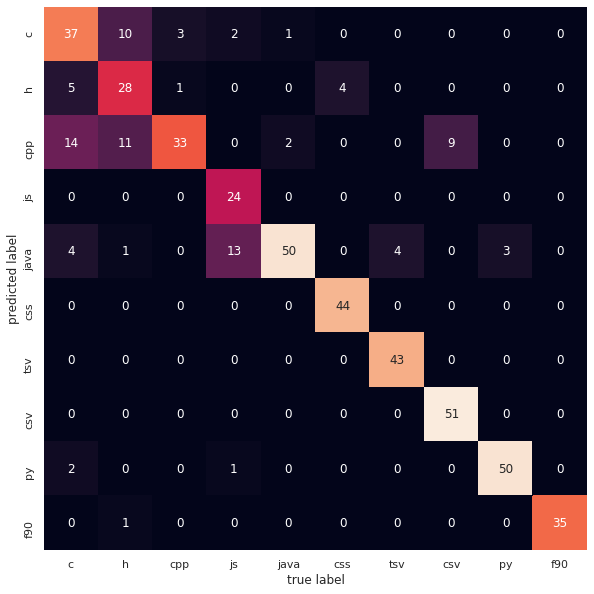

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.figure(figsize=(10,10))

mat = confusion_matrix(test_target, labels)
ax = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=fmt_dirs, yticklabels=fmt_dirs)
plt.xlabel('true label')
plt.ylabel('predicted label');
# Hack to avoid this issues: https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

We can now see that the approach is _very accurate_ for the _most_ of formats -- most of the bad results arise among the languages in the _C_ family. i.e. C/C++/JavaScript & Java are quite similar, and this is where the approach struggles.

There are a lot of different variations on this approach that could be explored in order to improve the situation, but these are promising initial results. 

### Potential future work

- Just train the classifier to spot the _C_ family, and trust the file extension beyond that.
- Keep some of the common language keywords rather than discarding all words.
- Experiment with different tokenisers and classifiers and their parameters.
- Just use trigram frequency comparison distance as the metric (i.e. O(N) in number of languages) rather than training a classifier?


## Addendum: GitHub Linguist

When I originally came up with this idea, GitHub Linguist was highly reliant upon file extension to determine language format. It has evolved significantly since then, and has adopted [a series of checks including a Baysian classifier](https://github.com/github/linguist#how-linguist-works).

Before pursuing development of a custom tool, it would be wise to re-evaluate Linguist and see if it can meet our needs.
